In [ ]:
import os

In [ ]:
os.chdir(r"C:\Users\DELL\Desktop\Presentation")

# Using API from Kaggle to download dataset

In [ ]:
!kaggle datasets download -d princeganer/bank-telemarketing-dataset

In [ ]:
!unzip bank-telemarketing-dataset.zip

In [ ]:
!dir

Sucessfully imported data from Kaggle API

## Importing libraries for further operations

In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import when, count
from pyspark.sql.functions import col, sum
import pyspark.pandas as ps
import findspark
findspark.init()

C:\Users\DELL\anaconda3\lib\site-packages\pyspark\pandas\__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
# create a sparksession
spark = SparkSession.builder.master('local[4]').appName('ml').getOrCreate()

In [3]:
# display function
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [4]:
# to display maximum columns in pandas
pd.pandas.set_option('display.max_columns', None)

# Data Preprocessing

## Bank Full (dataset-1)

In [5]:
# Read Spark Dataframe
bank_full = spark.read.csv('bank-full.csv', sep = ";" , header=True, inferSchema=True)

In [6]:
bank_full.count()

45211

In [7]:
display(bank_full.limit(5))

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [8]:
bank_full.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [9]:
# Adding the index columns 

new_cols = ["emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor_3m", "nr_employed"]
for column in new_cols:
    bank_full = bank_full.withColumn(column, bank_full["poutcome"] + 1)

In [10]:
display(bank_full.limit(5))

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,null,null,null,null,null
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,null,null,null,null,null
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,null,null,null,null,null
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,null,null,null,null,null
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,null,null,null,null,null


In [11]:
# map years into a dataframe

def year_mapper(data, start_yr, end_yr):
    """
        This function takes dataframe, start year of data, end year of data as input and
        returns a new dataframe having year column mapped to it.
    """
    month_lst = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

    # Make a copy of the original dataframe
    new_data = data.copy()

    # Insert a new "year" column filled with zeros
    new_data.insert(loc=0, column="year", value=0)

    # Set the first year to the start year
    current_year = int(start_yr)
    new_data.at[0, "year"] = current_year

    # Loop through the rows of the dataframe, updating the year column when the month changes
    for i in range(1, len(new_data)):
        # If the current month is earlier in the year than the previous month, increment the year
        if month_lst.index(new_data["month"][i]) < month_lst.index(new_data["month"][i-1]):
            current_year += 1

        new_data.at[i, "year"] = current_year

        # If the current year exceeds the end year, break out of the loop
        if current_year > end_yr:
            break

    return new_data

In [12]:
import warnings
# Use default index prevent overhead.
ps.set_option("compute.default_index_type", "distributed")

# Ignore warnings coming from Arrow optimizations.
warnings.filterwarnings("ignore")  

# To speed up dataset processing
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)

bank_full_pdf = bank_full.toPandas()

# Apply the function to the Pandas DataFrame
new_pandas_df = year_mapper(bank_full_pdf, 2008, 2010)

# Convert the updated Pandas DataFrame back to a PySpark DataFrame
bank_full = spark.createDataFrame(new_pandas_df)

In [13]:
display(bank_full.limit(5))

year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
2008,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,null,null,null,null,null
2008,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,null,null,null,null,null
2008,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,null,null,null,null,null
2008,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,null,null,null,null,null
2008,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,null,null,null,null,null


In [14]:
bank_full.groupBy("year").count().show()

+----+-----+
|year|count|
+----+-----+
|2008|27729|
|2009|14862|
|2010| 2620|
+----+-----+



### Index mapper

In [15]:
#Adding the missing index into the dataframes because it have the same values along the months

def map_index(new_data):

    index_2008 = {"may":{"emp_var_rate":1.1, "cons_price_idx":93.994, "cons_conf_idx":-36.4, "euribor_3m":4.85, "nr_employed":5191},
                 "jun":{"emp_var_rate":1.4, "cons_price_idx":94.465, "cons_conf_idx":-41.8, "euribor_3m":4.86, "nr_employed":5228.1},
                 "jul":{"emp_var_rate":1.4, "cons_price_idx":93.918, "cons_conf_idx":-42.7, "euribor_3m":4.96, "nr_employed":5228.1},
                 "aug":{"emp_var_rate":1.4, "cons_price_idx":93.444, "cons_conf_idx":-36.1, "euribor_3m":4.965, "nr_employed":5228.1},
                 "oct":{"emp_var_rate":-0.1, "cons_price_idx":93.798, "cons_conf_idx":-40.4, "euribor_3m":5, "nr_employed":5195.8},
                 "nov":{"emp_var_rate":-0.1, "cons_price_idx":93.2, "cons_conf_idx":-42, "euribor_3m":4.406, "nr_employed":5195.8},
                 "dec":{"emp_var_rate":-0.2, "cons_price_idx":92.75, "cons_conf_idx":-45.9, "euribor_3m":3.563, "nr_employed":5176.3}}

    index_2009 = {"jan":{"emp_var_rate":-0.2, "nr_employed":5176.3},
                  "feb":{"emp_var_rate":-0.2, "nr_employed":5176.3},
                  "mar":{"emp_var_rate":-1.8, "cons_price_idx":92.84, "cons_conf_idx":-50, "euribor_3m":1.811, "nr_employed":5099.1},
                  "apr":{"emp_var_rate":-1.8, "cons_price_idx":93.075, "cons_conf_idx":-47.1, "euribor_3m":1.498, "nr_employed":5099.1},
                  "may":{"emp_var_rate":-1.8, "cons_price_idx":92.89, "cons_conf_idx":-46.2, "euribor_3m":1.334, "nr_employed":5099.1},
                 "jun":{"emp_var_rate":-2.9, "cons_price_idx":92.963, "cons_conf_idx":-40.8, "euribor_3m":1.26, "nr_employed":5076.2},
                 "jul":{"emp_var_rate":-2.9, "cons_price_idx":93.469, "cons_conf_idx":-33.6, "euribor_3m":1.072, "nr_employed":5076.2},
                 "aug":{"emp_var_rate":-2.9, "cons_price_idx":92.201, "cons_conf_idx":-31.4, "euribor_3m":0.884, "nr_employed":5076.2},
                 "sep":{"emp_var_rate":-3.4, "cons_price_idx":92.379, "cons_conf_idx":-29.8, "euribor_3m":0.813, "nr_employed":5017.5},
                 "oct":{"emp_var_rate":-3.4, "cons_price_idx":92.431, "cons_conf_idx":-26.9, "euribor_3m":0.754, "nr_employed":5017.5},
                 "nov":{"emp_var_rate":-3.4, "cons_price_idx":92.649, "cons_conf_idx":-30.1, "euribor_3m":0.722, "nr_employed":5017.5},
                 "dec":{"emp_var_rate":-3.0, "cons_price_idx":92.713, "cons_conf_idx":-33, "euribor_3m":0.718, "nr_employed":5023.5}}

    index_2010 = {"jan":{"emp_var_rate":-3.0, "nr_employed":5023.5},
                  "feb":{"emp_var_rate":-3.0, "nr_employed":5023.5},
                   "mar":{"emp_var_rate":-1.8, "cons_price_idx":92.369, "cons_conf_idx":-34.8, "euribor_3m":0.655, "nr_employed":5008.7},
                  "apr":{"emp_var_rate":-1.8, "cons_price_idx":93.749, "cons_conf_idx":-34.6, "euribor_3m":0.64, "nr_employed":5008.7},
                  "may":{"emp_var_rate":-1.8, "cons_price_idx":93.876, "cons_conf_idx":-40, "euribor_3m":0.668, "nr_employed":5008.7},
                 "jun":{"emp_var_rate":-1.7, "cons_price_idx":94.055, "cons_conf_idx":-39.8, "euribor_3m":0.704, "nr_employed":4991.6},
                 "jul":{"emp_var_rate":-1.7, "cons_price_idx":94.215, "cons_conf_idx":-40.3, "euribor_3m":0.79, "nr_employed":4991.6},
                 "aug":{"emp_var_rate":-1.7, "cons_price_idx":94.027, "cons_conf_idx":-38.3, "euribor_3m":0.898, "nr_employed":4991.6},
                 "sep":{"emp_var_rate":-1.1, "cons_price_idx":94.199, "cons_conf_idx":-37.5, "euribor_3m":0.886, "nr_employed":4963.6},
                 "oct":{"emp_var_rate":-1.1, "cons_price_idx":94.601, "cons_conf_idx":-49.5, "euribor_3m":0.959, "nr_employed":4963.6},
                 "nov":{"emp_var_rate":-1.1, "cons_price_idx":94.767, "cons_conf_idx":-50.8, "euribor_3m":1.05, "nr_employed":4963.6}}

    indx = [index_2008, index_2009, index_2010]
    years = [2008, 2009, 2010]
    
    for i in range(len(years)):
        for months, indexes in indx[i].items():
            for index, index_val in indexes.items():
                new_data = new_data.withColumn(index, 
                    when((col('year') == years[i]) & (col('month') == months), index_val).otherwise(col(index))) 
    return new_data

In [16]:
# Calling the index_mapper function
bank_full = map_index(new_data = bank_full)
display(bank_full.limit(5))

year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
2008,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2008,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2008,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2008,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2008,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0


In [17]:
bank_full.printSchema()

root
 |-- year: long (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor_3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)



In [18]:
#dropping the balance, day column
bank_full = bank_full.drop("balance", "day")

In [19]:
#Converting the dataframes into the pandas
dataframe_1 = bank_full.toPandas()

In [20]:
dataframe_1.head()

,year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
0,2008,58,management,married,tertiary,no,yes,no,unknown,may,261,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
1,2008,44,technician,single,secondary,no,yes,no,unknown,may,151,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2,2008,33,entrepreneur,married,secondary,no,yes,yes,unknown,may,76,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
3,2008,47,blue-collar,married,unknown,no,yes,no,unknown,may,92,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
4,2008,33,unknown,single,unknown,no,no,no,unknown,may,198,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0


In [21]:
#dataframe_1.to_csv('dataframe_1.csv')

### Bank Full Dataset (dataset-2)

In [22]:
# Read Spark Dataframe
bank_add_full = spark.read.csv('bank-additional-full.csv', sep=";", header=True, inferSchema=True)

In [23]:
bank_add_full.count()

41188

In [24]:
display(bank_add_full.limit(5))

age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [25]:
# Use default index prevent overhead.
ps.set_option("compute.default_index_type", "distributed")

warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations.

# To speed up dataset processing
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)

bank_full_pdf = bank_add_full.toPandas()

# Apply the function to the Pandas DataFrame
new_pandas_df = year_mapper(bank_full_pdf, 2008, 2010)

# Convert the updated Pandas DataFrame back to a PySpark DataFrame
bank_add_full = spark.createDataFrame(new_pandas_df)

### replace values from 999 to -1

In [26]:
#changes the values from 999 to -1
bank_add_full = bank_add_full.withColumn("pdays", when(col("pdays") == 999, -1).otherwise(col("pdays")))

### Renaming columns names and values

In [27]:
#Replacing the columns names
old_col_list = ["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
for i in range(0, len(old_col_list)):
    bank_add_full = bank_add_full.withColumnRenamed(old_col_list[i], new_cols[i])

In [28]:
#Renaming the categories names from education columns
old_edu = ["basic.4y", "high.school", "basic.6y", "basic.9y", "university.degree", "professional.course"]
new_edu = ["basic_4y", "high_school", "basic_6y", "basic_9y", "university_degree" ,"professional_course"]

for i in range(0,6):
    bank_add_full = bank_add_full.withColumn("education", when(col("education") == old_edu[i], new_edu[i]).otherwise(col("education")))

In [29]:
display(bank_add_full.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
2008,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,57,services,married,high_school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,37,services,married,high_school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,40,admin.,married,basic_6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,56,services,married,high_school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [30]:
bank_full.printSchema()

root
 |-- year: long (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor_3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)



In [31]:
#dropping the column day_of week
bank_add_full = bank_add_full.drop("day_of_week")

In [32]:
dataframe_2 = bank_add_full.toPandas()

In [33]:
#dataframe_2.to_csv('dataframe_2.csv')

## Concat two dataframes

In [34]:
#Concating two dataframes
frames  = [dataframe_1, dataframe_2]

bank = pd.concat(frames)

In [35]:
bank.head()

,year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
0,2008,58,management,married,tertiary,no,yes,no,unknown,may,261,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
1,2008,44,technician,single,secondary,no,yes,no,unknown,may,151,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2,2008,33,entrepreneur,married,secondary,no,yes,yes,unknown,may,76,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
3,2008,47,blue-collar,married,unknown,no,yes,no,unknown,may,92,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
4,2008,33,unknown,single,unknown,no,no,no,unknown,may,198,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0


In [36]:
#bank.to_csv('final_data.csv')
bank.to_parquet("bank_data_pdf.parquet")

In [37]:
# read the parquet file
bank_data = spark.read.parquet('bank_data_pdf.parquet')
#bank_data = spark.read.csv('final_data.csv',header=True,inferSchema=True)

In [38]:
#dropping id
bank_data = bank_data.drop("_c0")

In [39]:
display(bank_data.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,__index_level_0__
2008,58,management,married,tertiary,no,yes,no,unknown,may,261,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0,0
2008,44,technician,single,secondary,no,yes,no,unknown,may,151,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0,1
2008,33,entrepreneur,married,secondary,no,yes,yes,unknown,may,76,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0,2
2008,47,blue-collar,married,unknown,no,yes,no,unknown,may,92,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0,3
2008,33,unknown,single,unknown,no,no,no,unknown,may,198,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0,4


In [40]:
bank_data.printSchema()

root
 |-- year: long (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor_3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- __index_level_0__: long (nullable = true)



In [41]:
bank_data.count()

86399

In [42]:
#prints the summary of dataframes with std, means and quartiles
bank_data.summary()

summary,year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,__index_level_0__
count,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,86399,82347,82347,82347,86399,86399
mean,2008.4127131101054,40.50137154365213,null,null,null,null,null,null,null,null,258.2212062639614,2.670285535712219,20.68106112339263,0.3861271542494705,null,null,0.0520955103653224,93.57679853548213,-40.48362053264231,3.638350553146894,5166.518884484254,21646.080776397874
stddev,0.5921767877884162,10.534861414565343,null,null,null,null,null,null,null,null,258.36274637491704,2.947825240834214,75.26914071561545,1.7130601312833402,null,null,1.552601159884045,0.5794941097707781,4.625350257118373,1.7260917956494208,71.3463353713149,12551.457936477302
min,2008,17,admin.,divorced,basic_4y,no,no,no,cellular,apr,0,1,-1,0,failure,no,-3.4,92.201,-50.8,0.634,4963.6,0
25%,2008,32,null,null,null,null,null,null,null,null,103,1,-1,0,null,null,-1.8,93.075,-42.7,1.334,5099.1,10798
50%,2008,39,null,null,null,null,null,null,null,null,180,2,-1,0,null,null,1.1,93.749,-41.8,4.85,5191.0,21596
75%,2009,48,null,null,null,null,null,null,null,null,319,3,-1,0,null,null,1.4,93.994,-36.4,4.96,5228.1,32399
max,2010,98,unknown,unknown,unknown,yes,yes,yes,unknown,sep,4918,63,871,275,unknown,yes,1.4,94.767,-26.9,5.045,5228.1,45210


In [43]:
#seperating the continuous and categorical variables
cat_col = ["job","marital","education","default","housing","loan","contact","month","year","y"]
cont_col = ["age","duration","campaign","pdays","previous","emp_var_rate","cons_price_idx","cons_conf_idx","euribor_3m","nr_employed"]
categories = bank_data.select(cat_col)
continuous = bank_data.select(cont_col)

### Unique value counts

In [44]:
#Prints the value counts for categrical columns
for columns in categories:
    print("Column Name", columns)
    print("-----------------------")
    counts = bank_data.groupBy(columns).count()
    counts.show()
    print("     ")
    print("******************************************************")
    print("     ")

Column Name Column<'job'>
-----------------------
+-------------+-----+
|          job|count|
+-------------+-----+
|   management|12382|
|      retired| 3984|
|      unknown|  618|
|self-employed| 3000|
|      student| 1813|
|  blue-collar|18986|
| entrepreneur| 2943|
|       admin.|15593|
|   technician|14340|
|     services| 8123|
|    housemaid| 2300|
|   unemployed| 2317|
+-------------+-----+

     
******************************************************
     
Column Name Column<'marital'>
-----------------------
+--------+-----+
| marital|count|
+--------+-----+
| unknown|   80|
|divorced| 9819|
| married|52142|
|  single|24358|
+--------+-----+

     
******************************************************
     
Column Name Column<'education'>
-----------------------
+-------------------+-----+
|          education|count|
+-------------------+-----+
|professional_course| 5243|
|           basic_4y| 4176|
|            unknown| 3588|
|           tertiary|13301|
|           basic_9y

## Data Preparation

In [45]:
#Rename .admin category to admin
bank_data = bank_data.withColumn("job", when(col("job") == "admin.", "admin").otherwise(col("job")))

In [46]:
#Replacing "unknown" and "nonexistent" with the null values
for column in bank_data.columns:
    bank_data = bank_data.withColumn(column, when(col(column).isin("unknown", "nonexistent"), None).otherwise(col(column)))

In [47]:
display(bank_data.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,__index_level_0__
2008,58,management,married,tertiary,no,yes,no,null,may,261,1,-1,0,null,no,1.1,93.994,-36.4,4.85,5191.0,0
2008,44,technician,single,secondary,no,yes,no,null,may,151,1,-1,0,null,no,1.1,93.994,-36.4,4.85,5191.0,1
2008,33,entrepreneur,married,secondary,no,yes,yes,null,may,76,1,-1,0,null,no,1.1,93.994,-36.4,4.85,5191.0,2
2008,47,blue-collar,married,null,no,yes,no,null,may,92,1,-1,0,null,no,1.1,93.994,-36.4,4.85,5191.0,3
2008,33,null,single,null,no,no,no,null,may,198,1,-1,0,null,no,1.1,93.994,-36.4,4.85,5191.0,4


### Checking for null values

In [48]:
# Checks the null values for categorical values
bank_data.agg(*[count(when(col(c).isNull(), c)).alias(c) for c in categories.columns]).show()

+---+-------+---------+-------+-------+----+-------+-----+----+---+
|job|marital|education|default|housing|loan|contact|month|year|  y|
+---+-------+---------+-------+-------+----+-------+-----+----+---+
|618|     80|     3588|   8597|    990| 990|  13020|    0|   0|  0|
+---+-------+---------+-------+-------+----+-------+-----+----+---+



In [49]:
# Checks the null values for continuous values
bank_data.agg(*[count(when(col(c).isNull(), c)).alias(c) for c in continuous.columns]).show()

+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+
|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|
+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+
|  0|       0|       0|    0|       0|           0|          4052|         4052|      4052|          0|
+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+



### Replacing continue variables

In [50]:
from pyspark.sql.functions import mean

# calculate the mean of non-null values in columns
mean_dict = bank_data.select(*(mean(c).alias(c) for c in cont_col)).first().asDict()

# replace null values with the mean
bank_data = bank_data.fillna(mean_dict)

In [51]:
#checking for null values
bank_data.agg(*[count(when(col(c).isNull(), c)).alias(c) for c in continuous.columns]).show()

+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+
|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|
+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+
|  0|       0|       0|    0|       0|           0|             0|            0|         0|          0|
+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+



### Replacing categorical variables

In [52]:
bank_data = bank_data.drop("poutcome")

In [53]:
# calculate the mode of non-null values and replaced in columns
from pyspark.sql.functions import desc
for column in cat_col:
    mode = bank_data.groupBy(column).agg(count("*").alias("count")).orderBy(desc("count")).select(column).first()[0]
    bank_data = bank_data.fillna({column: mode})

In [54]:
#checking for null values
bank_data.agg(*[count(when(col(c).isNull(), c)).alias(c) for c in categories.columns]).show()

+---+-------+---------+-------+-------+----+-------+-----+----+---+
|job|marital|education|default|housing|loan|contact|month|year|  y|
+---+-------+---------+-------+-------+----+-------+-----+----+---+
|  0|      0|        0|      0|      0|   0|      0|    0|   0|  0|
+---+-------+---------+-------+-------+----+-------+-----+----+---+



In [55]:
pdf=bank_data.toPandas()

### Heatmap

<AxesSubplot:>

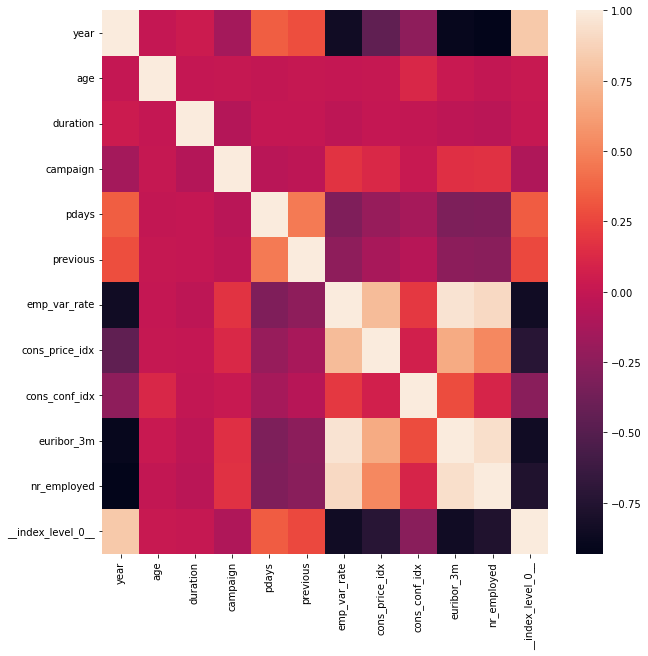

In [56]:
correlation = pdf.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation)

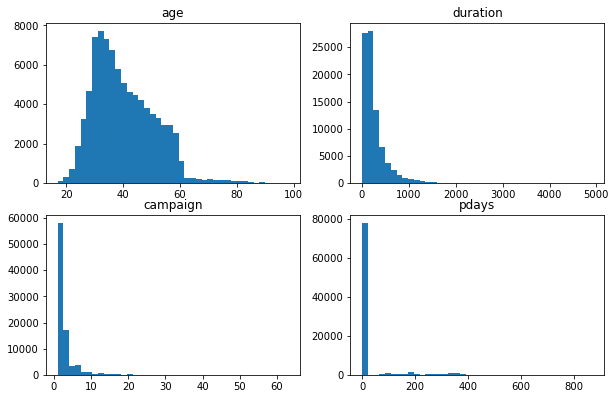

In [57]:
# function to plot the normal distribution
def plot_dist():
    plt.figure(figsize=(10,10))
    plt.subplot(3,2,1)
    plt.hist(pdf["age"], bins = 40)
    plt.title('age')

    plt.subplot(3,2,2)
    plt.hist(pdf["duration"], bins = 40)
    plt.title('duration')

    plt.subplot(3,2,3)
    plt.hist(pdf["campaign"], bins = 40)
    plt.title('campaign')
    
    plt.subplot(3,2,4)
    plt.hist(pdf["pdays"], bins = 40)
    plt.title('pdays')
         
plot_dist()

## ordinal data encoding

In [58]:
# Creating a dictionary for converting categorical textual data entries
# conversion into categorical numeric values on basis on job profile
job_dict = {"entrepreneur":11, "self-employed":10, "admin":9, "management":8, "services":7, 
       "technician":6, "blue-collar":5, "housemaid":4, "retired":3, "student":2, "unemployed":1}

for key, value in job_dict.items():
    bank_data = bank_data.withColumn("job", when(bank_data["job"] == key, int(value)).otherwise(bank_data["job"]))

In [59]:
# conversion into categorical numeric values on basis on marital status
marital_dict = {"married":3, "single":2, "divorced":1}

for key, value in marital_dict.items():
    bank_data = bank_data.withColumn("marital", when(bank_data["marital"] == key, value).otherwise(bank_data["marital"]))

In [60]:
# conversion into categorical numeric values on basis on education
edu_dict = {"professional_course":10, "university_degree":9, "tertiary":8, "secondary":7, 
       "high_school":6, "basic_9y":5, "basic_6y":4, "primary":3, "basic_4y":2, "illiterate":1}

for key, value in edu_dict.items():
    bank_data = bank_data.withColumn("education", when(bank_data["education"] == key, value).otherwise(bank_data["education"]))

In [61]:
y_dict = {"yes":1, "no":0}

for key, value in y_dict.items():
    bank_data = bank_data.withColumn("y", when(bank_data["y"] == key, value).otherwise(bank_data["y"]))

In [62]:
display(bank_data.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,__index_level_0__
2008,58,8,3,8,no,yes,no,cellular,may,261,1,-1,0,0,1.1,93.994,-36.4,4.85,5191.0,0
2008,44,6,2,7,no,yes,no,cellular,may,151,1,-1,0,0,1.1,93.994,-36.4,4.85,5191.0,1
2008,33,11,3,7,no,yes,yes,cellular,may,76,1,-1,0,0,1.1,93.994,-36.4,4.85,5191.0,2
2008,47,5,3,7,no,yes,no,cellular,may,92,1,-1,0,0,1.1,93.994,-36.4,4.85,5191.0,3
2008,33,5,2,7,no,no,no,cellular,may,198,1,-1,0,0,1.1,93.994,-36.4,4.85,5191.0,4


In [63]:
#Conversion of months into the quarters
quarter_dict = {"jan":"Q1", "feb":"Q1", "mar":"Q1", "apr":"Q2", "may":"Q2", "jun":"Q2", 
                "jul":"Q3", "aug":"Q3", "sep":"Q3", "oct":"Q4", "nov":"Q4", "dec":"Q4"}

for key, value in quarter_dict.items():
    bank_data = bank_data.withColumn("month", when(bank_data["month"] == key, value).otherwise(bank_data["month"]))

In [64]:
bank_data.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = false)
 |-- marital: string (nullable = false)
 |-- education: string (nullable = false)
 |-- default: string (nullable = false)
 |-- housing: string (nullable = false)
 |-- loan: string (nullable = false)
 |-- contact: string (nullable = false)
 |-- month: string (nullable = false)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- y: string (nullable = false)
 |-- emp_var_rate: double (nullable = false)
 |-- cons_price_idx: double (nullable = false)
 |-- cons_conf_idx: double (nullable = false)
 |-- euribor_3m: double (nullable = false)
 |-- nr_employed: double (nullable = false)
 |-- __index_level_0__: long (nullable = true)



In [65]:
bank = bank_data

### one hot encoding

In [66]:
#One hot encoding on the nominal data
one_hot_cols = ["default", "housing", "loan"]

for i in one_hot_cols:
    bank = bank.withColumn(i, when(col(i) == "yes", 1).
                              when(col(i) == "no", 0).
                              otherwise(col(i)))
    
bank = bank.withColumn("contact", when(col("contact") == "telephone", 1)
                                  .when(col("contact") == "cellular", 0)
                                  .otherwise(col("contact")))

In [67]:
from pyspark.ml.feature import StringIndexer

# StringIndexer specifies i/p and o/p columns
indexer = StringIndexer(inputCol='month', outputCol='class_numeric')

# fit the data and then converts string to numerical values
indexer_fitted = indexer.fit(bank)
df_indexed = indexer_fitted.transform(bank)

# One_hot_encoder converts the above output into the vectors
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCols=['class_numeric'], outputCols=['class_onehot'])
df_onehot = encoder.fit(df_indexed).transform(df_indexed)

# One_hot_encoder converts the above output into the Array
from pyspark.ml.functions import vector_to_array
df_col_onehot = df_onehot.select('*', vector_to_array('class_onehot').alias('Quarter'))

import pyspark.sql.functions as F
num_categories = len(df_col_onehot.first()['Quarter'])
cols_expanded = [(F.col('Quarter')[i].alias(f'{indexer_fitted.labels[i]}')) for i in range(num_categories)]
bank_df = df_col_onehot.select("year","age","job","marital","education","default","housing","loan","contact",
                                      "month","duration","campaign","pdays","previous","emp_var_rate","cons_price_idx",
                                      "cons_conf_idx","euribor_3m","nr_employed","y",*cols_expanded)


In [68]:
display(bank_df.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,Q2,Q3,Q4
2008,58,8,3,8,0,1,0,0,Q2,261,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0,1.0,0.0,0.0
2008,44,6,2,7,0,1,0,0,Q2,151,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0,1.0,0.0,0.0
2008,33,11,3,7,0,1,1,0,Q2,76,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0,1.0,0.0,0.0
2008,47,5,3,7,0,1,0,0,Q2,92,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0,1.0,0.0,0.0
2008,33,5,2,7,0,0,0,0,Q2,198,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0,1.0,0.0,0.0


In [69]:
bank_df.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = false)
 |-- marital: string (nullable = false)
 |-- education: string (nullable = false)
 |-- default: string (nullable = false)
 |-- housing: string (nullable = false)
 |-- loan: string (nullable = false)
 |-- contact: string (nullable = false)
 |-- month: string (nullable = false)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- emp_var_rate: double (nullable = false)
 |-- cons_price_idx: double (nullable = false)
 |-- cons_conf_idx: double (nullable = false)
 |-- euribor_3m: double (nullable = false)
 |-- nr_employed: double (nullable = false)
 |-- y: string (nullable = false)
 |-- Q2: double (nullable = true)
 |-- Q3: double (nullable = true)
 |-- Q4: double (nullable = true)



In [70]:
bank_data = bank_df

In [71]:
bank_data = bank_data.drop("month")

### Converting string datatype to double

In [72]:
column_types = bank_data.dtypes
# Filter the list to only include the string datatype columns

string_columns = [column[0] for column in column_types if column[1] == "string"]
print(string_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'y']


In [73]:
for cols in string_columns:
# Change the datatype of the columns to double
    bank_data = bank_data.withColumn(cols, bank_data[cols].cast("double"))

In [74]:
display(bank_data.limit(5))

year,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,Q2,Q3,Q4
2008,58,8.0,3.0,8.0,0.0,1.0,0.0,0.0,261,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,44,6.0,2.0,7.0,0.0,1.0,0.0,0.0,151,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,33,11.0,3.0,7.0,0.0,1.0,1.0,0.0,76,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,47,5.0,3.0,7.0,0.0,1.0,0.0,0.0,92,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,33,5.0,2.0,7.0,0.0,0.0,0.0,0.0,198,1,-1,0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0


In [75]:
bank_data.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: integer (nullable = true)
 |-- job: double (nullable = true)
 |-- marital: double (nullable = true)
 |-- education: double (nullable = true)
 |-- default: double (nullable = true)
 |-- housing: double (nullable = true)
 |-- loan: double (nullable = true)
 |-- contact: double (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- emp_var_rate: double (nullable = false)
 |-- cons_price_idx: double (nullable = false)
 |-- cons_conf_idx: double (nullable = false)
 |-- euribor_3m: double (nullable = false)
 |-- nr_employed: double (nullable = false)
 |-- y: double (nullable = true)
 |-- Q2: double (nullable = true)
 |-- Q3: double (nullable = true)
 |-- Q4: double (nullable = true)



### Outliers visualization and removal

In [76]:
out = bank_data.toPandas()

In [77]:
outliers_columns = ["age","duration","campaign","pdays","previous"]

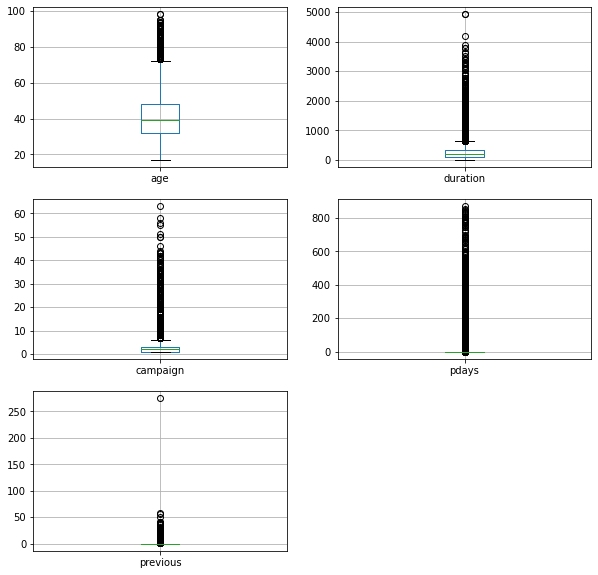

In [78]:
#Function defination to plot the outliers
def plot_box():
    plt.figure(figsize=(10,10))
    plt.subplot(3,2,1)
    out.boxplot(column=["age"])

    plt.subplot(3,2,2)
    out.boxplot(column=["duration"])

    plt.subplot(3,2,3)
    out.boxplot(column=["campaign"])

    plt.subplot(3,2,4)
    out.boxplot(column=["pdays"])

    plt.subplot(3,2,5)
    out.boxplot(column=["previous"])
           
plot_box()

In [79]:
#Removing the outliers with the help of maximum binding limit
max_out_limit = []
for cols in outliers_columns:
    quantiles = bank_data.approxQuantile(cols, [0.25, 0.5, 0.75], 0.01)
    
    q3 = quantiles[2]
    q1 = quantiles[0]
    iqr = q3 - q1
    iqr = iqr*1.5
    max_limit = q3 + iqr
    min_limit = q1 - iqr
    max_out_limit.append(max_limit)
    
    print(cols, "max_limit: ",max_limit,"      min_limit: ",min_limit)
else:
    print("------------------------------------------")
    print(max_out_limit)



age max_limit:  72.0       min_limit:  8.0
duration max_limit:  644.5       min_limit:  -223.5
campaign max_limit:  6.0       min_limit:  -2.0
pdays max_limit:  -1.0       min_limit:  -1.0
previous max_limit:  0.0       min_limit:  0.0
------------------------------------------
[72.0, 644.5, 6.0, -1.0, 0.0]


In [80]:
for i, j in zip(outliers_columns, max_out_limit):
    bank_data = bank_data.withColumn(i, 
                    when((col(i) >= j), j).otherwise(col(i))) 

In [81]:
out = bank_data.toPandas()

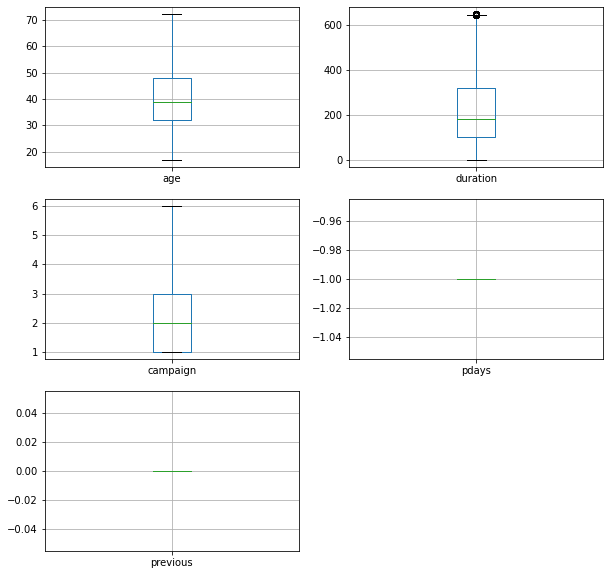

In [82]:
plot_box()

In [83]:
bank_data.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: double (nullable = true)
 |-- job: double (nullable = true)
 |-- marital: double (nullable = true)
 |-- education: double (nullable = true)
 |-- default: double (nullable = true)
 |-- housing: double (nullable = true)
 |-- loan: double (nullable = true)
 |-- contact: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- campaign: double (nullable = true)
 |-- pdays: double (nullable = true)
 |-- previous: double (nullable = true)
 |-- emp_var_rate: double (nullable = false)
 |-- cons_price_idx: double (nullable = false)
 |-- cons_conf_idx: double (nullable = false)
 |-- euribor_3m: double (nullable = false)
 |-- nr_employed: double (nullable = false)
 |-- y: double (nullable = true)
 |-- Q2: double (nullable = true)
 |-- Q3: double (nullable = true)
 |-- Q4: double (nullable = true)



## pyspark model Building

In [84]:
bank = bank_data

In [85]:
display(bank.limit(5))

year,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,Q2,Q3,Q4
2008,58.0,8.0,3.0,8.0,0.0,1.0,0.0,0.0,261.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,44.0,6.0,2.0,7.0,0.0,1.0,0.0,0.0,151.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,33.0,11.0,3.0,7.0,0.0,1.0,1.0,0.0,76.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,47.0,5.0,3.0,7.0,0.0,1.0,0.0,0.0,92.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0
2008,33.0,5.0,2.0,7.0,0.0,0.0,0.0,0.0,198.0,1.0,-1.0,0.0,1.1,93.994,-36.4,4.85,5191.0,0.0,1.0,0.0,0.0


## Data Oversampling of "yes" label in y

In [86]:
# Data oversampling function of the "yes" lebel in the dependent column
def over_sample( data, oversampling_ratio ):
    """
        This method takes in an imbalanced dataframe and it returns a
        new dataframe with oversampled minority rows according to the
        oversampling ratio provided.
    """
    import math

    # avoid changing the original object accidentally
    new_data = data.toPandas()
    

    nums = new_data['y'].value_counts()
    num_n = nums[0]
    num_y = nums[1]
    nums = len(new_data["y"])

    new_y = ( (1 - oversampling_ratio) / oversampling_ratio)*num_n
   
    loop_num = int( math.ceil(new_y/num_y) )

    new_df = new_data[ new_data["y"] == 1.0 ]
   
    for i in range(0, loop_num-1):
       
        # randomly select all rows from new_df
        random_rows = new_df.sample(n = num_y, replace=True, random_state = 14)
        
        # append the selected row to bank_df
        new_data = new_data.append(random_rows, ignore_index=True)
       
    new_data = spark.createDataFrame(new_data)
    return new_data

In [87]:
bank_oversampled_df = over_sample(data = bank, oversampling_ratio = 0.6)

In [88]:
# Value counts for y column
bank_oversampled_df.groupBy("y").count().show()

+---+-----+
|  y|count|
+---+-----+
|0.0|76470|
|1.0|59574|
+---+-----+



In [89]:
bank = bank_oversampled_df

In [90]:
out = bank.toPandas()
out.to_csv('ML.csv')

## Data Scaling

In [91]:
#Min_max scaling to the selected columns
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler


numerical_cols = ['year', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 
                  'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 
                  'nr_employed', 'Q2', 'Q3', 'Q4']

#numerical_cols = ['year', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'duration', 
                   #'cons_price_idx', 'Q4']


# Create a vector assembler to combine the numerical columns into a single vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")

# Transform the DataFrame to create the numerical features vector
bank = assembler.transform(bank)

# Apply MinMaxScaler to the numerical features vector
scaler = MinMaxScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")
scaler_model = scaler.fit(bank)
df = scaler_model.transform(bank)

df = df.drop("numerical_features")

# Drop the original numerical columns and keep only the scaled numerical features
bank = df.drop(*numerical_cols).withColumnRenamed("scaled_numerical_features", "sc_features")


In [92]:
display(bank.limit(5))

campaign,pdays,previous,y,sc_features
1.0,-1.0,0.0,0.0,"[0.0,0.7454545454..."
1.0,-1.0,0.0,0.0,"[0.0,0.4909090909..."
1.0,-1.0,0.0,0.0,"[0.0,0.2909090909..."
1.0,-1.0,0.0,0.0,"[0.0,0.5454545454..."
1.0,-1.0,0.0,0.0,"[0.0,0.2909090909..."


In [93]:
banks = bank

In [94]:
#getting the names of columns of the dataframe
feature = []
for columns in banks.columns:
    feature.append(columns)
else:
    print(feature)

['campaign', 'pdays', 'previous', 'y', 'sc_features']


In [95]:
banks.count()

136044

In [96]:
#train test split: train data percentage: 70% and test data percentage: 30%
train_data, test_data = banks.randomSplit([0.70, 0.30], seed = 14)
display(train_data.limit(5))

campaign,pdays,previous,y,sc_features
1.0,-1.0,0.0,0.0,"(18,[0,1,2,4,9,10..."
1.0,-1.0,0.0,0.0,"(18,[0,1,2,4,9,10..."
1.0,-1.0,0.0,0.0,"(18,[0,1,2,4,9,10..."
1.0,-1.0,0.0,0.0,"(18,[0,1,2,4,9,10..."
1.0,-1.0,0.0,0.0,"(18,[0,1,2,4,9,10..."


In [97]:
# train data counts
train_data.count()

95006

In [98]:
# test data counts
test_data.count()

41038

## Decision Tree Classifier

In [99]:
#Decision tree Algorithm
from pyspark.ml.classification import DecisionTreeClassifier as dtc
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report

In [100]:
dt = dtc(labelCol="y",featuresCol='sc_features')
dt_model = dt.fit(train_data)

#Predict the values on test data
dt_predictions = dt_model.transform(test_data)

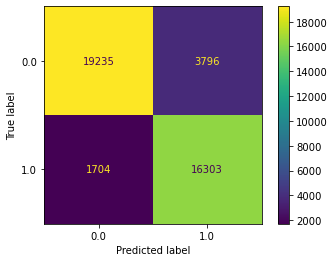

In [101]:
dt_pred = dt_predictions.select('prediction').toPandas()
actual = dt_predictions.select('y').toPandas()

#Shows confusion Report
ConfusionMatrixDisplay.from_predictions(actual, dt_pred)

In [102]:
#Prints Classification Report
print(classification_report(actual, dt_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.84      0.87     23031
         1.0       0.81      0.91      0.86     18007

    accuracy                           0.87     41038
   macro avg       0.86      0.87      0.87     41038
weighted avg       0.87      0.87      0.87     41038



## Logistic Regression

In [103]:
from pyspark.ml.classification import LogisticRegression

In [104]:
lr = LogisticRegression(featuresCol = 'sc_features',
                        labelCol = 'y',
                        maxIter=1000)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

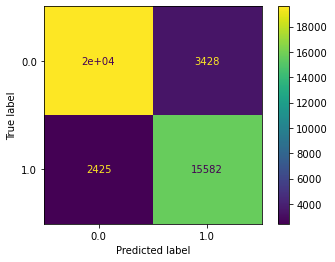

In [105]:
lr_pred = lr_predictions.select('prediction').toPandas()
actual = lr_predictions.select('y').toPandas()

ConfusionMatrixDisplay.from_predictions(actual, lr_pred)

In [106]:
print(classification_report(actual, lr_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87     23031
         1.0       0.82      0.87      0.84     18007

    accuracy                           0.86     41038
   macro avg       0.85      0.86      0.86     41038
weighted avg       0.86      0.86      0.86     41038



## Support Vector Machines

              precision    recall  f1-score   support

         0.0       0.89      0.84      0.86     23031
         1.0       0.81      0.86      0.83     18007

    accuracy                           0.85     41038
   macro avg       0.85      0.85      0.85     41038
weighted avg       0.85      0.85      0.85     41038



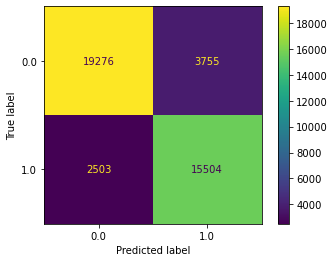

In [107]:
from pyspark.ml.classification import LinearSVC

# Load training data
lsvc = LinearSVC(featuresCol = 'sc_features', labelCol = 'y', maxIter=10, regParam=0.1)

# Fit the model
lsvcModel = lsvc.fit(train_data)

svc_predictions = lsvcModel.transform(test_data)

svc_pred = svc_predictions.select('prediction').toPandas()
actual = svc_predictions.select('y').toPandas()

ConfusionMatrixDisplay.from_predictions(actual, svc_pred)

print(classification_report(actual, svc_pred))

## Random Forest

In [108]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='y', featuresCol = 'sc_features')
rf_model = rf.fit(train_data)
predictions = rf_model.transform(test_data)

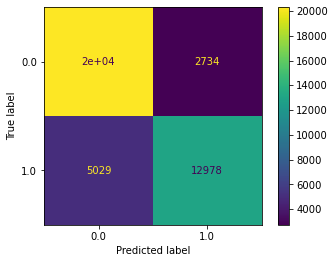

In [109]:
rf_prediction = rf_model.transform(test_data)
rf_preds = rf_prediction.select('prediction').toPandas()
actual = rf_prediction.select('y').toPandas()

ConfusionMatrixDisplay.from_predictions(actual, rf_preds)

In [110]:
print(classification_report(actual, rf_preds))

              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84     23031
         1.0       0.83      0.72      0.77     18007

    accuracy                           0.81     41038
   macro avg       0.81      0.80      0.80     41038
weighted avg       0.81      0.81      0.81     41038



## Grid Search CV

### Grid search_CV for Random forest

In [111]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col


# Define parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 10]) \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .build()

# Define evaluator
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol=lr.getLabelCol())

# Define cross-validator
cv = CrossValidator(estimator=rf, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Fit cross-validator to training data
cv_model = cv.fit(train_data)

# Evaluate model on test data
gcv_pred = cv_model.transform(test_data)
evaluator.evaluate(predictions)

0.9212106103103488

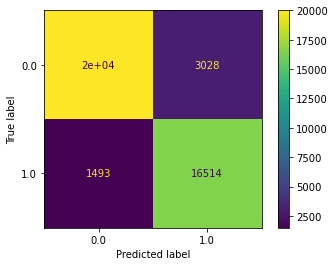

In [112]:
gcv_preds = gcv_pred.select('prediction').toPandas()
gcv_actual = gcv_pred.select('y').toPandas()

ConfusionMatrixDisplay.from_predictions(gcv_actual, gcv_preds)

In [113]:
print(classification_report(gcv_actual, gcv_preds))

              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90     23031
         1.0       0.85      0.92      0.88     18007

    accuracy                           0.89     41038
   macro avg       0.89      0.89      0.89     41038
weighted avg       0.89      0.89      0.89     41038



### Grid search_CV for Decision Tree

In [114]:
param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 10]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .build()

# Define evaluator
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol=dt.getLabelCol())

# Define cross-validator
cv = CrossValidator(estimator=dt, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Fit cross-validator to training data
cv_model = cv.fit(train_data)

# Evaluate model on test data
gcv_dt_pred = cv_model.transform(test_data)
evaluator.evaluate(predictions)

0.9212082183305241

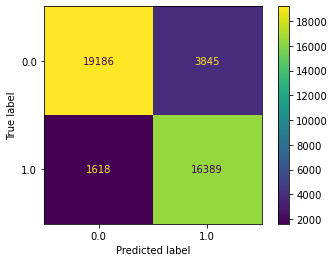

In [115]:
gcv_preds = gcv_dt_pred.select('prediction').toPandas()
gcv_actual = gcv_dt_pred.select('y').toPandas()

ConfusionMatrixDisplay.from_predictions(gcv_actual, gcv_preds)

In [116]:
print(classification_report(gcv_actual, gcv_preds))

              precision    recall  f1-score   support

         0.0       0.92      0.83      0.88     23031
         1.0       0.81      0.91      0.86     18007

    accuracy                           0.87     41038
   macro avg       0.87      0.87      0.87     41038
weighted avg       0.87      0.87      0.87     41038

